In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [3]:
df=pd.read_csv('Jamboree_Admission.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
df.shape

(500, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


# EDA

In [6]:
#droping serial No. as this is not a feature
df.drop(columns=['Serial No.'], inplace=True)

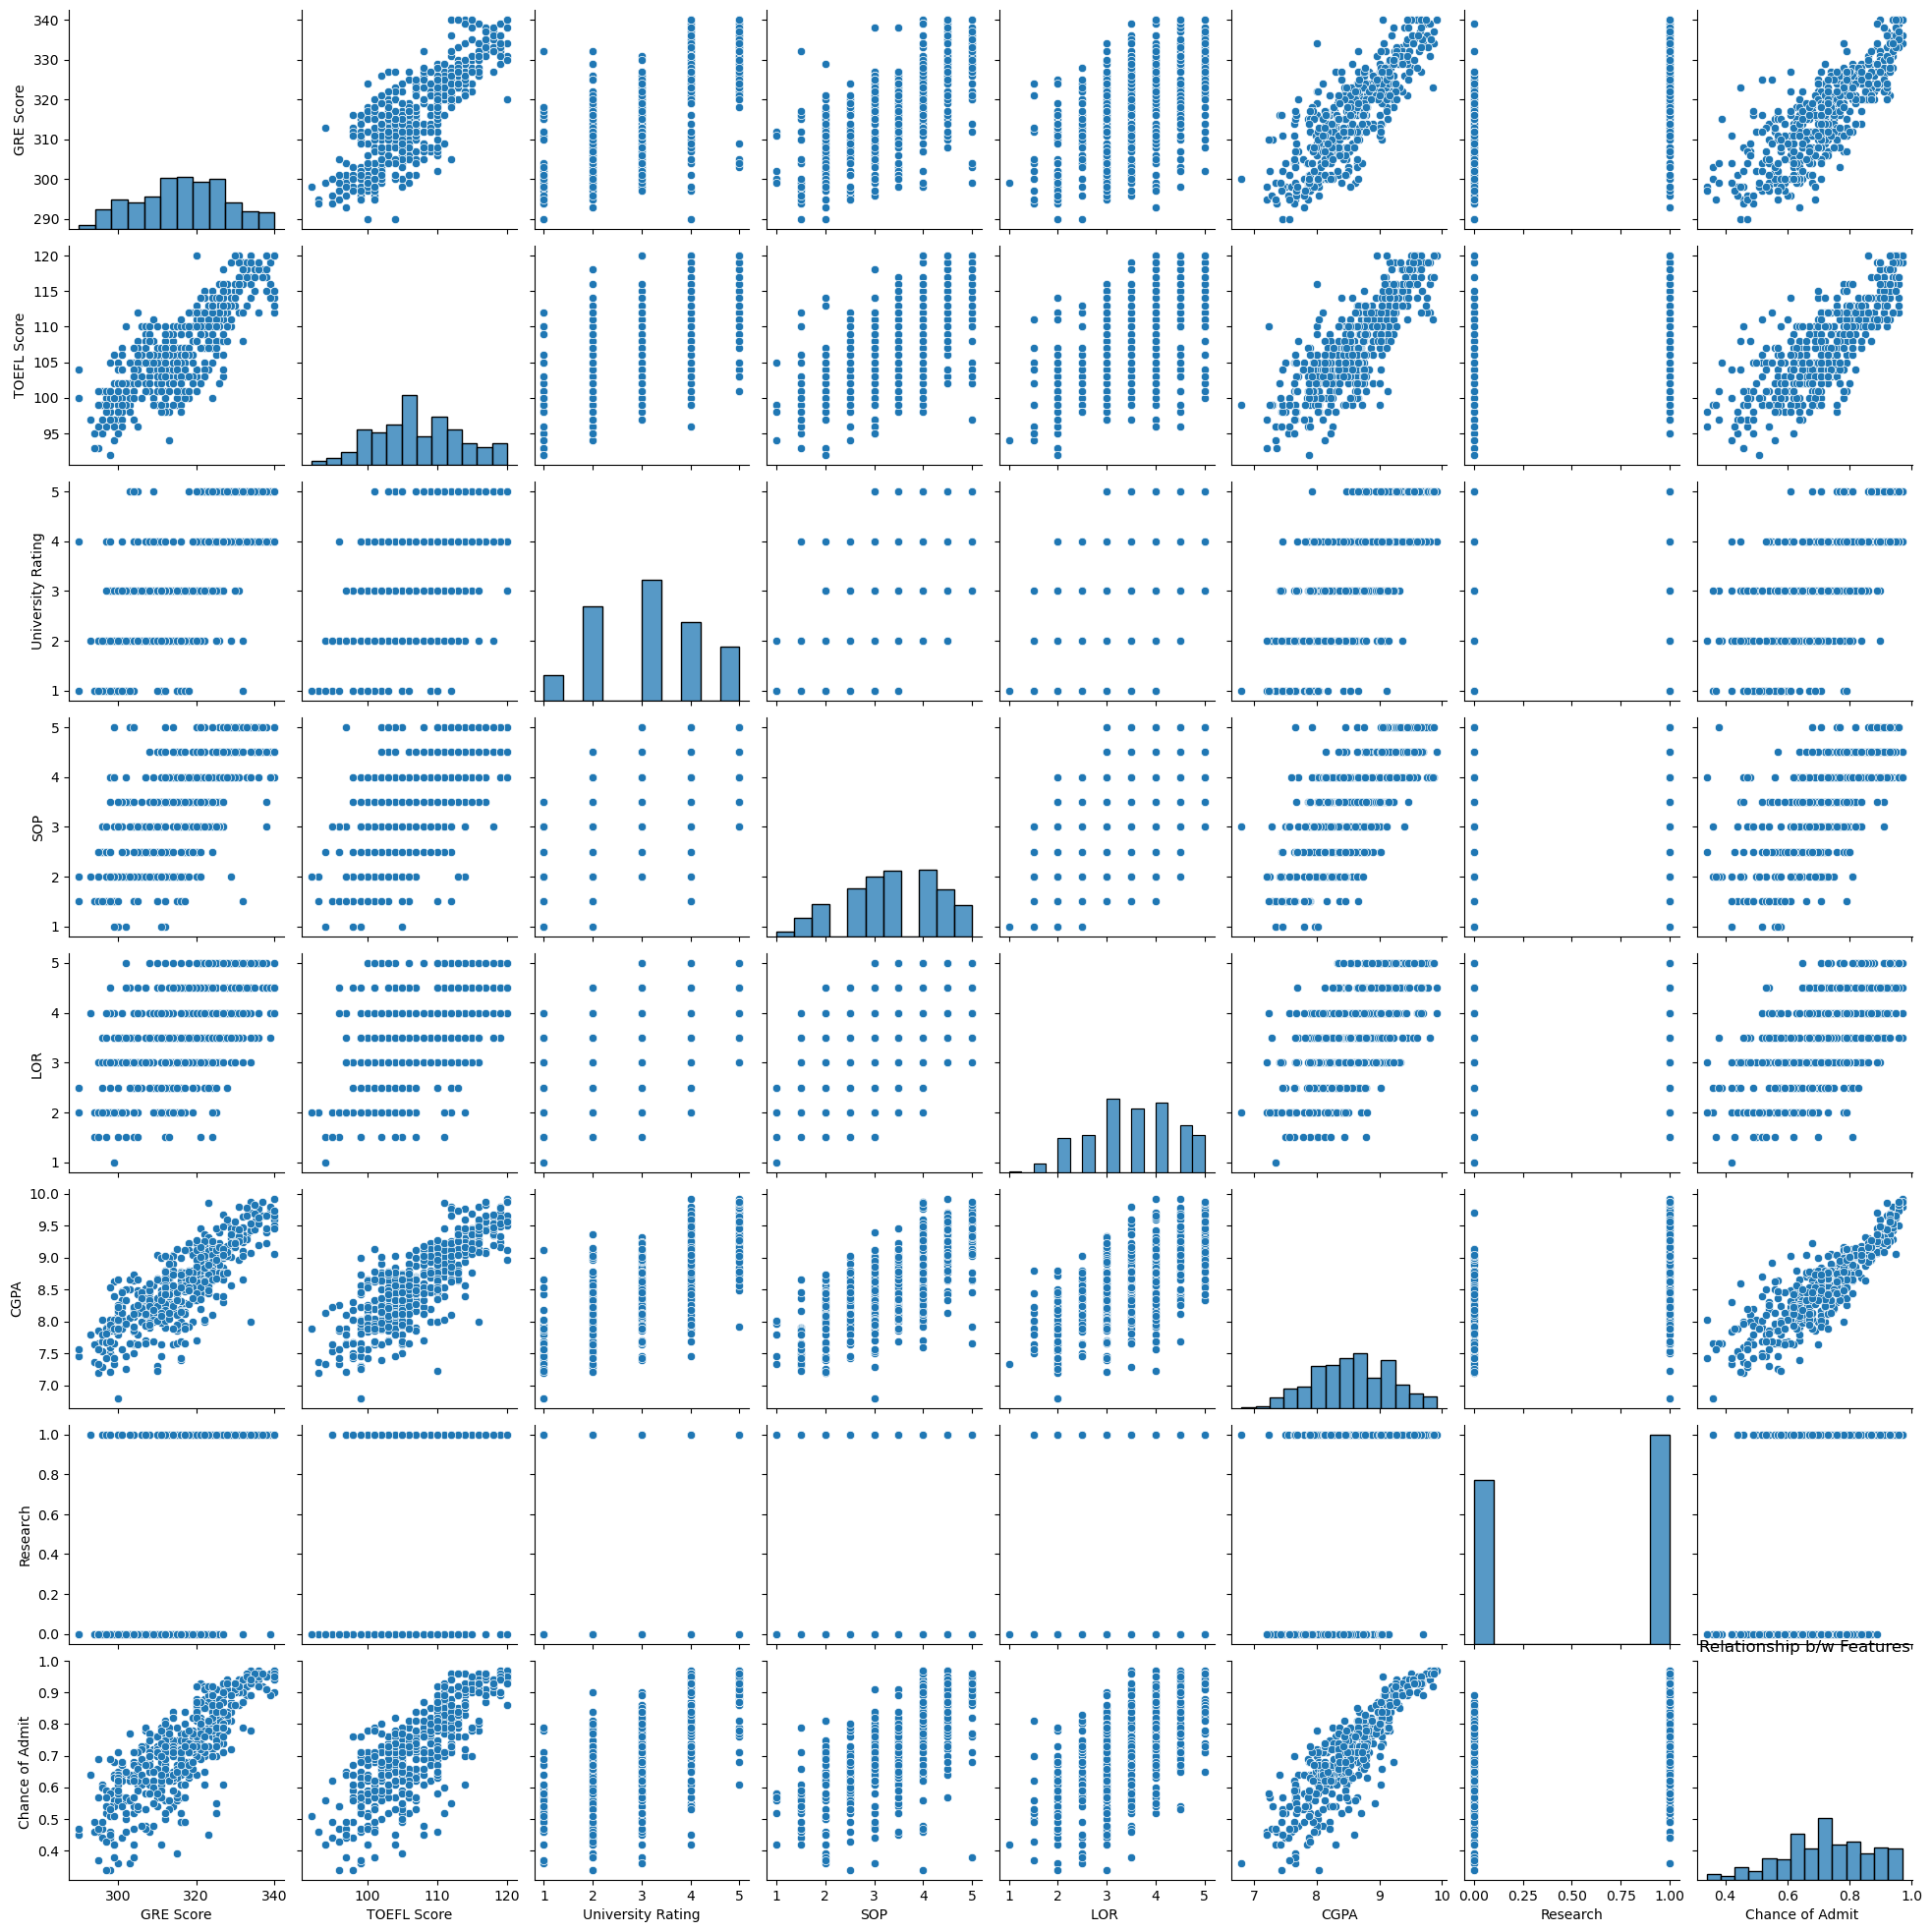

In [12]:
sns.pairplot(df)
plt.title('Relationship b/w Features')
plt.show()

- Exam scores (GRE, TOEFL and CGPA) have a high positive correlation with chance of admit
- While university ranking, rating of SOP and LOR also have an impact on chances of admit, research is the only variable which doesn't have much of an impact
- We can see from the scatterplot that the values of university ranking, SOP, LOR and research are not continuous. We can convert these columns to categorical variables

In [13]:
df.rename(columns={'LOR ':'LOR', 'Chance of Admit ':'Chance of Admit'}, inplace=True)

In [14]:
df[['University Rating', 'SOP', 'LOR']] = df[['University Rating', 'SOP', 'LOR']].astype('category')
df['Research'] = df['Research'].astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   GRE Score          500 non-null    int64   
 1   TOEFL Score        500 non-null    int64   
 2   University Rating  500 non-null    category
 3   SOP                500 non-null    category
 4   LOR                500 non-null    category
 5   CGPA               500 non-null    float64 
 6   Research           500 non-null    bool    
 7   Chance of Admit    500 non-null    float64 
dtypes: bool(1), category(3), float64(2), int64(2)
memory usage: 18.6 KB


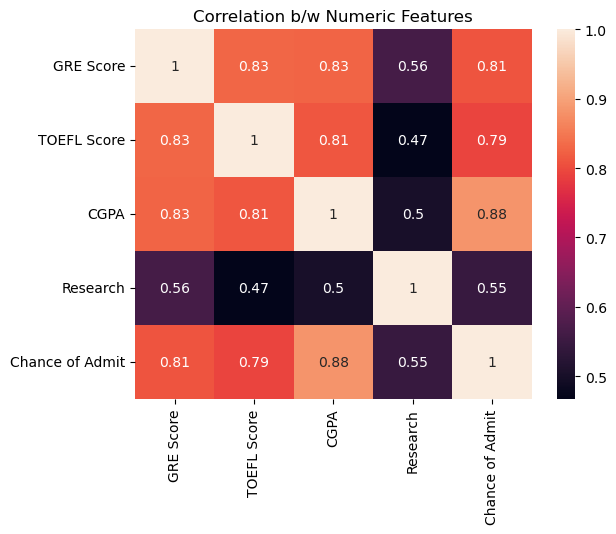

In [15]:
#Heatmap to analyse the correlation between numerical features and Chance of Admit
df_corr = df.corr(numeric_only=True)
sns.heatmap(df_corr, annot=True)
plt.title('Correlation b/w Numeric Features')
plt.show();

- Confirming the inferences from pairplot, the correlation matrix also shows that exam scores (CGPA/GRE/TOEFL) have a strong positive correlation with chance of admit
- Infact, they are also highly correlated amongst themselves

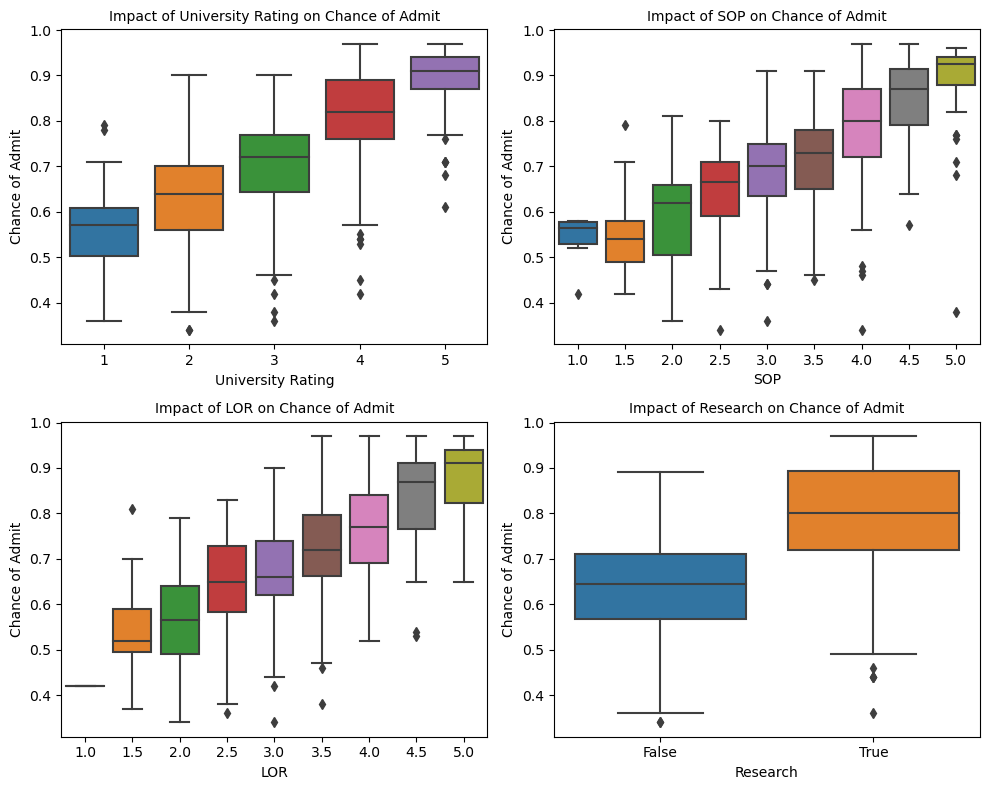

In [16]:
# Boxplots to analyse the relationship between categorical variables and Chance of Admit

cat_cols = df.select_dtypes(include=['bool','category']).columns.tolist()
plt.figure(figsize=(10,8))
i=1
for col in cat_cols:
  ax = plt.subplot(2,2,i)
  sns.boxplot(data = df, x=col, y='Chance of Admit')
  plt.title(f"Impact of {col} on Chance of Admit", fontsize=10)
  plt.xlabel(col)
  plt.ylabel('Chance of Admit')
  i+=1

plt.tight_layout()
plt.show()

- As seen in the pairplot earlier, the categorical variables such as university ranking, research, quality of SOP and LOR also increase the chances of admit.

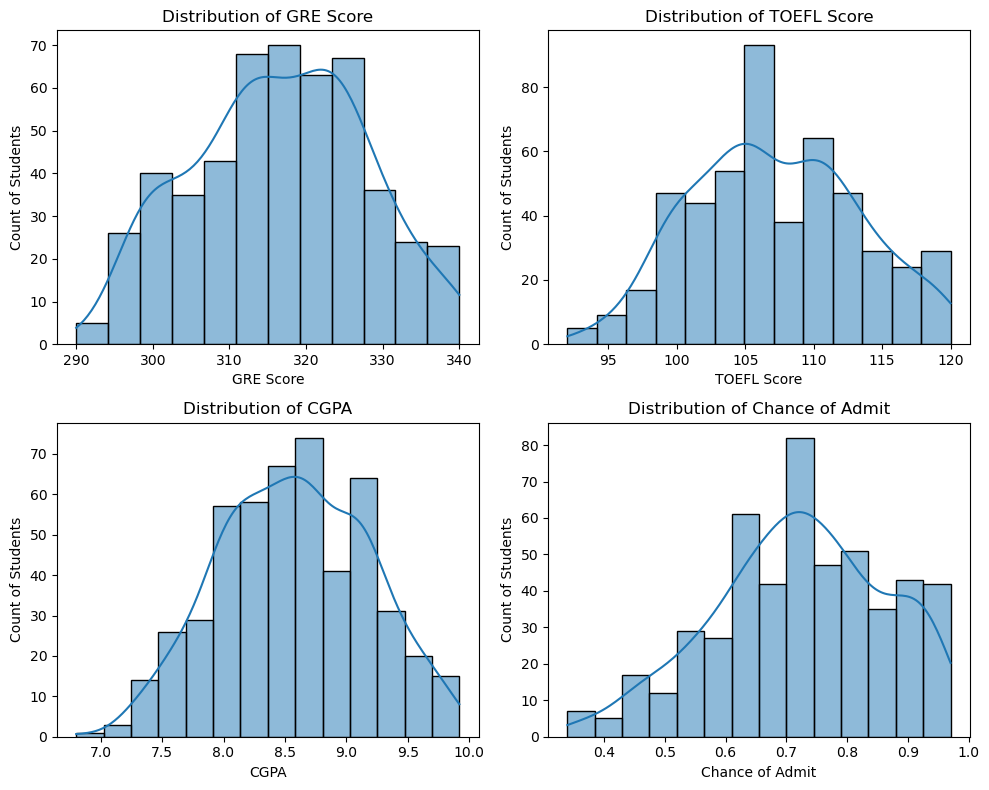

In [17]:
# Distribution of continuous numerical features
numeric_cols = df.select_dtypes(include=['float','int']).columns.tolist()

plt.figure(figsize=(10,8))
i=1
for col in numeric_cols:
  ax=plt.subplot(2,2,i)
  sns.histplot(data=df[col], kde=True)
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Count of Students')
  i += 1

plt.tight_layout()
plt.show()

We can see the range of all the numerical attributes:
* GRE scores are between 290 and 340, with maximum students scoring in the range 310-330
* TOEFL scores are between 90 and 120, with maximum students scoring around 105
* CGPA ranges between 7 and 10, with maximum students scoring around 8.5
* Chance of Admit is a probability percentage between 0 and 1, with maximum students scoring around 70%-75%

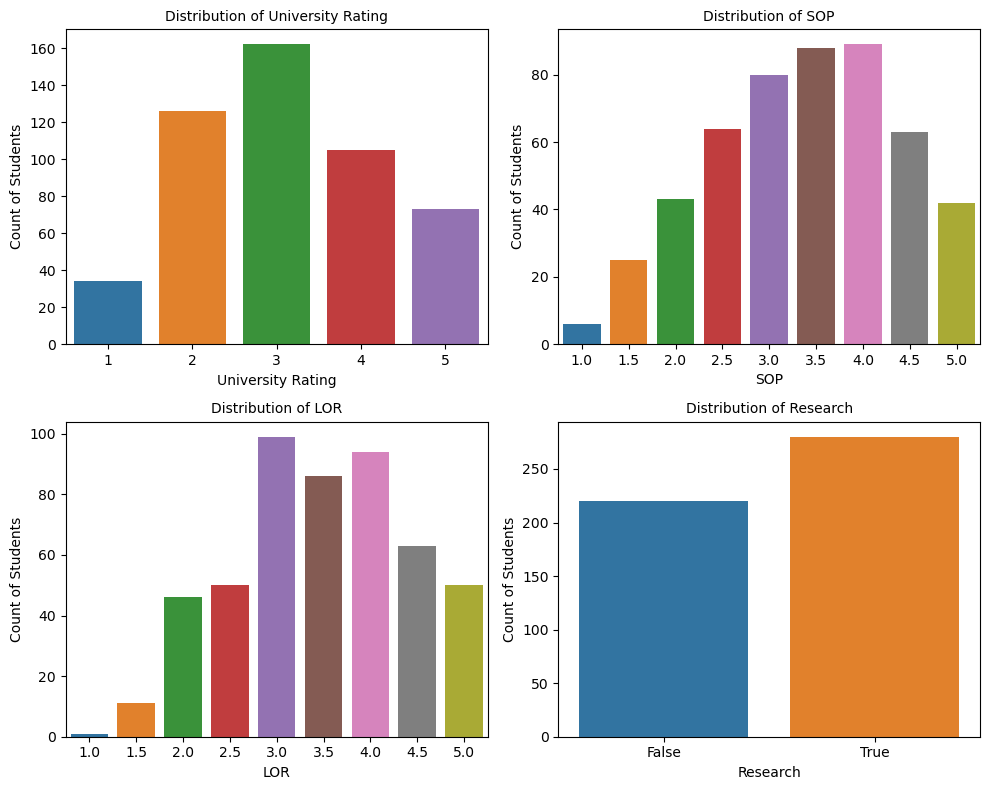

In [18]:
# Distribution of categorical variables
plt.figure(figsize=(10,8))
i=1

for col in cat_cols:
  ax = plt.subplot(2,2,i)
  sns.countplot(x=df[col])
  plt.title(f'Distribution of {col}', fontsize=10)
  plt.xlabel(col)
  plt.ylabel('Count of Students')
  i+=1

plt.tight_layout()
plt.show();

It can be observed that the most frequent value of categorical features is as following:
* University Rating: 3
* SOP: 3.5 & 4
* LOR: 3
* Research: True

# Data Preprocessing

## Missing Values/Outliers/Duplicates Check

In [19]:
#Check for missing values in all columns
df.isna().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

There are no missing values in the dataset

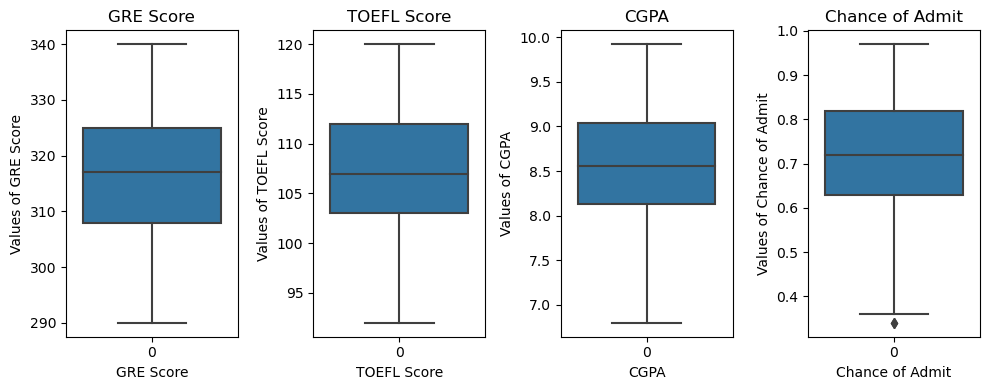

In [20]:
# Check for outliers in numerical columns
plt.figure(figsize=(10,4))
i=1

for col in numeric_cols:
  ax = plt.subplot(1,4,i)
  sns.boxplot(df[col])
  plt.title(col)
  plt.xlabel(col)
  plt.ylabel(f'Values of {col}')
  i+=1

plt.tight_layout()
plt.show()

It can be observed that there are no outliers in the numeric columns (all the observations are within the whiskers which represent the mimimum and maximum of the range of values)

In [21]:
# Check for Duplicate rows
df[df.duplicated()].shape

(0, 8)

There are no duplicate rows in the dataset

## Train-Test Split

In [22]:
numeric_cols.remove('Chance of Admit')

In [23]:
# Separate predictor and target variables
x = df[numeric_cols + cat_cols]
y = df[['Chance of Admit']]

In [24]:
x.head()

,GRE Score,TOEFL Score,CGPA,University Rating,SOP,LOR,Research
0,337,118,9.65,4,4.5,4.5,True
1,324,107,8.87,4,4.0,4.5,True
2,316,104,8.00,3,3.0,3.5,True
3,322,110,8.67,3,3.5,2.5,True
4,314,103,8.21,2,2.0,3.0,False


In [26]:
y.head()

,Chance of Admit
0,0.92
1,0.76
2,0.72
3,0.80
4,0.65


In [29]:
# Split the data into training and test data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                     random_state=42)

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of x_train: (400, 7)
Shape of x_test: (100, 7)
Shape of y_train: (400, 1)
Shape of y_test: (100, 1)


## Label Encoding & Standardisation

In [32]:
# Initialize a dictionary to store the label encoders
label_encoders = {}

# Loop through each categorical column and initialize the label encoder
for col in cat_cols:
    label_encoders[col] = LabelEncoder()

In [33]:
# Fitting encoders to the respective columns
for col in cat_cols:
  label_encoders[col].fit(x[col])

In [34]:
#Transforming categorical columns in the train and test data
for col in cat_cols:
  x_train[col] = label_encoders[col].transform(x_train[col])
  x_test[col] = label_encoders[col].transform(x_test[col])

In [37]:
x_cat_encoded = pd.concat([x_train, x_test])
x_cat_encoded.head(20)

,GRE Score,TOEFL Score,CGPA,University Rating,SOP,LOR,Research
249,321,111,8.83,2,5,6,1
433,316,111,8.54,3,6,8,0
19,303,102,8.50,2,5,4,0
322,314,107,8.27,1,3,6,0
332,308,106,8.21,2,5,3,1
56,316,102,7.40,2,2,4,0
301,319,108,8.76,1,3,4,0
229,324,111,9.01,3,4,4,1
331,311,105,8.12,1,4,2,1
132,309,105,8.56,4,5,5,0


In [36]:
label_encoders['SOP'].classes_

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [39]:
#Initialising object of class MinMaxScaler() for Standardisation
scaler_x = MinMaxScaler()

In [40]:
#Fitting scaler_x to the training data
scaler_x.fit(x_cat_encoded)

MinMaxScaler()

In [41]:
all_cols = x_train.columns

In [43]:
type(x_cat_encoded)

pandas.core.frame.DataFrame

In [44]:
#Transforming numeric columns of x_train and x_test
x_train[all_cols]=scaler_x.transform(x_train[all_cols])
x_test[all_cols]=scaler_x.transform(x_test[all_cols])

In [45]:
x_test.head()

,GRE Score,TOEFL Score,CGPA,University Rating,SOP,LOR,Research
361,0.88,0.857143,0.878205,0.75,0.750,0.625,1.0
73,0.48,0.571429,0.717949,0.75,0.875,0.750,1.0
374,0.50,0.464286,0.272436,0.25,0.250,0.375,0.0
155,0.44,0.607143,0.605769,0.50,0.500,0.500,0.0
104,0.72,0.714286,0.721154,0.50,0.625,0.500,1.0


# Base Model: Linear Regression

In [48]:
#Initialising object of Class LinearRegression()
model_lr = LinearRegression()

In [49]:
# Fitting the model to the training data
model_lr.fit(x_train, y_train)

LinearRegression()

In [50]:
# Predicting values for the training and test data
y_pred_train = model_lr.predict(x_train)
y_pred_test = model_lr.predict(x_test)

In [51]:
# Evaluating the model using multiple loss functions
def model_evaluation(y_actual, y_forecast, model):
  n = len(y_actual)
  if len(model.coef_.shape)==1:
    p = len(model.coef_)
  else:
    p = len(model.coef_[0])
  MAE = np.round(mean_absolute_error(y_true=y_actual, y_pred=y_forecast),2)
  RMSE = np.round(mean_squared_error(y_true=y_actual,
                                     y_pred=y_forecast, squared=False),2)
  r2 = np.round(r2_score(y_true=y_actual, y_pred=y_forecast),2)
  adj_r2 = np.round(1 - ((1-r2)*(n-1)/(n-p-1)),2)
  return print(f"MAE: {MAE}\nRMSE: {RMSE}\nR2 Score: {r2}\nAdjusted R2: {adj_r2}")

In [54]:
# Metrics for training data
model_evaluation(y_train.values, y_pred_train, model_lr)

MAE: 0.04
RMSE: 0.06
R2 Score: 0.82
Adjusted R2: 0.82


In [55]:
#Metrics for test data
model_evaluation(y_test.values, y_pred_test, model_lr)

MAE: 0.04
RMSE: 0.06
R2 Score: 0.82
Adjusted R2: 0.81


Since there is no difference in the loss scores of training and test data, we can conclude that there is no overfitting of the model

* Mean Absolute Error of 0.04 shows that on an average, the absolute difference between the actual and predicted values of chance of admit is 4%
* Root Mean Square Error of 0.06 means that on an average, the root of squared difference between the actual and predicted values is 6%
* R2 Score of 0.82 means that our model captures 82% variance in the data
* Adjusted R2 is an extension of R2 which shows how the number of features used changes the accuracy of the prediction

In [56]:
# Model Coefficients

for feature,weight in zip(x_train.columns, model_lr.coef_[0]):
  print(f"Weight of {feature}: {np.round(weight,2)}")

Weight of GRE Score: 0.12
Weight of TOEFL Score: 0.08
Weight of CGPA: 0.35
Weight of University Rating: 0.01
Weight of SOP: 0.01
Weight of LOR: 0.07
Weight of Research: 0.02


In [57]:
# Bias Term of the Model

model_lr.intercept_

array([0.34696506])

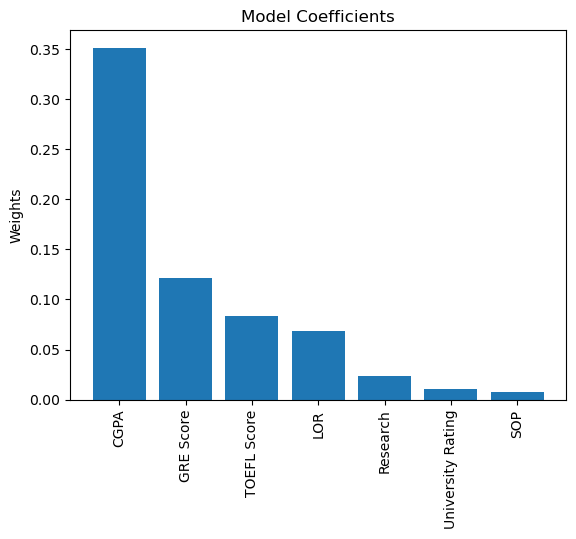

In [58]:
model_weights=list(zip(x_train.columns, model_lr.coef_[0]))
model_weights.sort(key=lambda x:x[1], reverse=True)

features = [i[0] for i in model_weights]
weights = [i[1] for i in model_weights]

plt.bar(x=features, height=weights)
plt.title('Model Coefficients')
plt.ylabel('Weights')
plt.xticks(rotation=90)
plt.show();

* CGPA & GRE scores have the highest weight
* SOP, University rating, and research have the lowest weights

# Testing Assumptions of Linear Regression Model

## Multicolinearity Check

VIF (Variance Inflation Factor) is a measure that quantifies the severity of multicollinearity in a regression analysis. It assesses how much the variance of the estimated regression coefficient is inflated due to collinearity.

The formula for VIF is as follows:

VIF(j) = 1 / (1 - R(j)^2)


In [61]:
vif = pd.DataFrame()
vif['Variable'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif

,Variable,VIF
0,GRE Score,31.185925
1,TOEFL Score,26.753950
2,CGPA,41.732265
3,University Rating,10.837374
4,SOP,18.864173
5,LOR,14.657099
6,Research,3.366187


We see that almost all the variables (excluding research) have a very high level of colinearity. This was also observed from the correlation heatmap which showed strong positive correlation between GRE score, TOEFL score and CGPA.

## Mean of Residuals

In [62]:
residuals = y_test.values - y_pred_test
residuals.reshape((-1,))
print('Mean of Residuals: ', residuals.mean())

Mean of Residuals:  -0.0054536237176612675


Since the mean of residuals is very close to 0, we can say that the model is unbiased

## Linearity of Variables

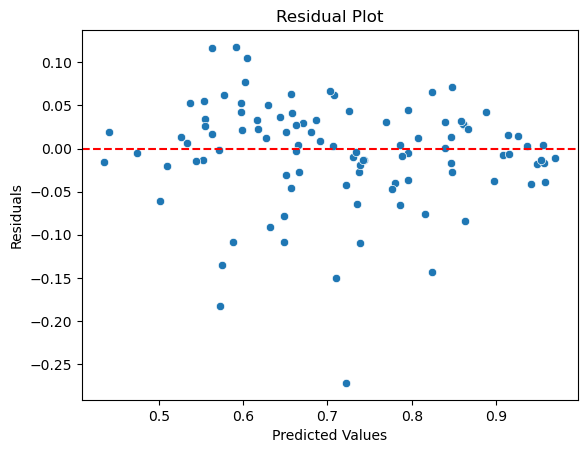

In [63]:
sns.scatterplot(x = y_pred_test.reshape((-1,)), y=residuals.reshape((-1,)))
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show();

Since the residual plot shows no clear pattern or trend in residuals, we can conclude that linearity of variables exists

## Homoscedasticity

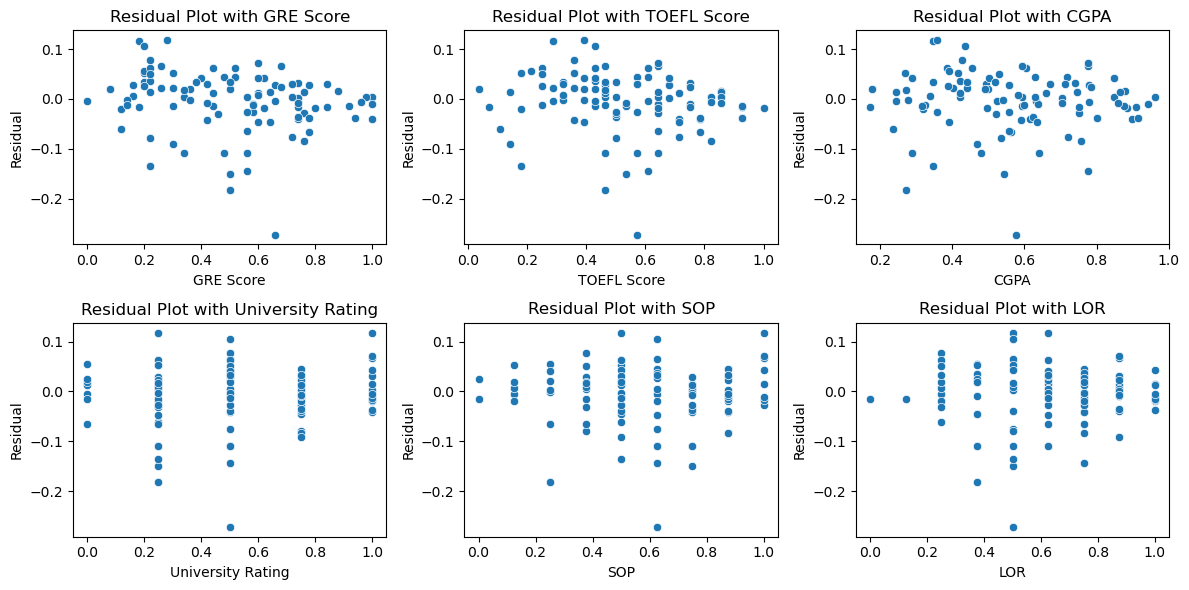

In [64]:
# Scatterplot of residuals with each independent variable to check for Homoscedasticity
plt.figure(figsize=(12,6))
i=1
for col in x_test.columns[:-1]:
  ax = plt.subplot(2,3,i)
  sns.scatterplot(x=x_test[col].values.reshape((-1,)), y=residuals.reshape((-1,)))
  plt.title(f'Residual Plot with {col}')
  plt.xlabel(col)
  plt.ylabel('Residual')
  i+=1

plt.tight_layout()
plt.show()

Since we do not see any significant change in the spread of residuals with respect to change in independent variables, we can conclude that homoscedasticity is met.

## Normality of Residuals

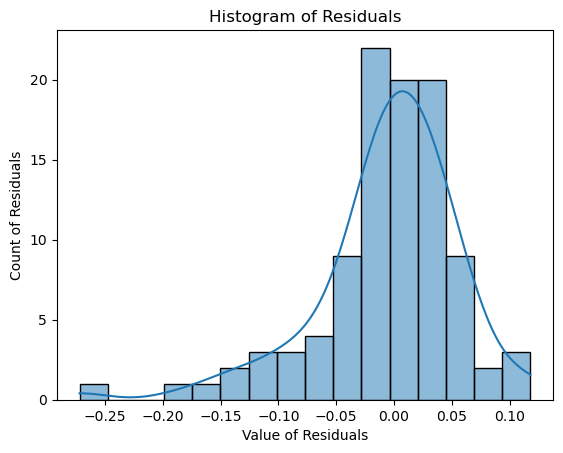

In [65]:
#Histogram of Residuals
sns.histplot(residuals.reshape((-1,)), kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Value of Residuals')
plt.ylabel('Count of Residuals')
plt.show();

The histogram shows that there is a negative skew in the distribution of residuals but it is close to a normal distribution

# Lasso and Ridge Regression

In [66]:
# Initialising instance of Ridge and Lasso classes
model_ridge = Ridge()
model_lasso = Lasso()

In [67]:
# Fitting the models to training data
model_ridge.fit(x_train, y_train)
model_lasso.fit(x_train, y_train)

Lasso()

In [68]:
# Predicting values for train and test data

y_train_ridge = model_ridge.predict(x_train)
y_test_ridge = model_ridge.predict(x_test)

y_train_lasso = model_lasso.predict(x_train)
y_test_lasso = model_lasso.predict(x_test)

In [69]:
# Evaluating Model Performance
print('Ridge Regression Training Accuracy\n')
model_evaluation(y_train.values, y_train_ridge, model_ridge)
print('\n\nRidge Regression Test Accuracy\n')
model_evaluation(y_test.values, y_test_ridge, model_ridge)
print('\n\nLasso Regression Training Accuracy\n')
model_evaluation(y_train.values, y_train_lasso, model_lasso)
print('\n\nLasso Regression Test Accuracy\n')
model_evaluation(y_test.values, y_test_lasso, model_lasso)

Ridge Regression Training Accuracy

MAE: 0.04
RMSE: 0.06
R2 Score: 0.82
Adjusted R2: 0.82


Ridge Regression Test Accuracy

MAE: 0.04
RMSE: 0.06
R2 Score: 0.82
Adjusted R2: 0.81


Lasso Regression Training Accuracy

MAE: 0.11
RMSE: 0.14
R2 Score: 0.0
Adjusted R2: -0.02


Lasso Regression Test Accuracy

MAE: 0.12
RMSE: 0.14
R2 Score: -0.01
Adjusted R2: -0.09


While Linear Regression and Ridge regression have similar scores, Lasso regression has not performed well on both training and test data

# Insights & Recommendations

Insights:
* The distribution of target variable (chances of admit) is left-skewed
* Exam scores (CGPA/GRE/TOEFL) have a strong positive correlation with chance of admit. These variables are also highly correlated amongst themselves
* the categorical variables such as university ranking, research, quality of SOP and LOR also show an upward trend for chances of admit.
* From the  model coefficients (weights), we can conclude that CGPA is the most significant predictor variable while SOP/University Rating are the least significant
* Both Linear Regression and Ridge Regression models, which are our best models, have captured upto 82% of the variance in the target variable (chance of admit). Due to high colinearity among the predictor variables, it is difficult to achieve better results.
* Other than multicolinearity, the predictor variables have met the conditions required for Linear Regression - mean of residuals is close to 0, linearity of variables, normality of residuals and homoscedasticity is established.

Recommendations:
* Since all the exam scores are highly correlated, it is recommended to add more independent features for better prediction.
* Examples of other independent variables could be work experience, internships, mock interview performance, extracurricular activities or diversity variables